**datamask_2018.tif**:
    
    is a layer that has values 0,1,2,or -1.
            0 for no data
            1 for mapped land surface
            2 for permanent woter bodies
            -1 for masked pixel

**gain_2018.tif**

        is a layer that has values 0,1,or -1.
            0 for no gain experienced between 2001 and 2012
            1 for gain experienced between 2001 and 2012
            -1. for masked pixel
        
**treecover2000_2018.tif**

        is a layer that has values between 0,100,or -1.
            value between 0 and 100 indicates percentage three cover observed.
            -1 for masked pixel


**if_in_buffer.tif**

        is a layer that has values 0,1,or -1.
            0 if a pixel lies
            1 if a pixel lies in the buffer area
            -1 for masked pixel
            
The first three files are produced form the files:
    datamask
    gain
    treecover2000
    
    Downladed from:
    https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.6.html

For how if_in_buffer.tif was created see R notebook.    

  **lossyear_2018.tif**
    
    Downladed from:
    https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.6.html
    contains the most recent lossyear file.
    
    layer with values 0,1,2,3,..18 or -1
        0 for no loss experienced between 2001 and 2018
        1,2,3..18 for loss experienced in 2001, 2002, 2003,..2018
        -1 for masked pixel
    
    
    last_2018_1.tif
    last_2018_2.tif
    last_2018_3.tif
    last_2018_4.tif
    
    The "last" file 4 bands corresponding to year 2018
    each has values between 0:255 or -1
        masked pixels have value -1

<img src="images/table.png">

Load needed packages.

sourcepath is the path to folder that has all tiff files.

wherepath is the path to folder where the tensors to be saved and loaded later

In [ ]:
import torch
from torchvision.transforms import ToTensor
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from torch.utils.data import Dataset
import os.path
import numpy as np


server = '/rds/general/project/aandedemand/live/satellite/junin'

sourcepath = '/data_reduced'
wherepath = '/data_reduced/tensors'

sourcepath = server + sourcepath
wherepath = server + wherepath
print(sourcepath, wherepath)

/rds/general/project/aandedemand/live/satellite/junin/data_reduced /rds/general/project/aandedemand/live/satellite/junin/data_reduced/tensors


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import time
print('done')

done


In [ ]:
def to_Tensor(path,name):
    """
    Load Tiff files as tensors
    """
    t = Image.open(path+"/"+name)
    t = ToTensor()(t)
    t = t.squeeze(dim = 0)
    return(t)

## datamask

<Figure size 1008x1008 with 0 Axes>

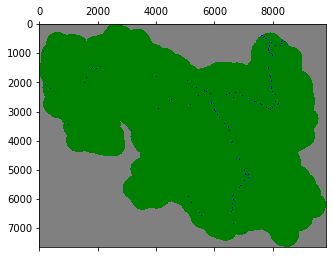

Number of pixels in AOI and buffer with no data (0 entries):  0


In [ ]:
datamask = to_Tensor(sourcepath,'Hansen/datamask_2018.tif')


#visualise:
colors = ['grey','white','green','blue']
plt.fig = plt.figure(figsize=(14,14))
plt.matshow(datamask,cmap=matplotlib.colors.ListedColormap(colors))
plt.show()
print("Number of pixels in AOI and buffer with no data (0 entries): ", len((datamask == 0).nonzero()))

Since for AOI area all pixels have value $\neq 0$, to rescale this layer to be in range 0,1 we change encoding as follows:
     
     datamask:
    -1 for NA value
    0 for land pixel in AOI
    1 for water body pixel in AOI

by running this line:

    datamask[datamask !=  -1] = datamask[datamask !=  -1] - 1

In [ ]:
datamask[datamask !=  -1] = datamask[datamask !=  -1] - 1

## if_in_buffer

## DSM - new layer

In [ ]:
values = (DSM != -1).nonzero()
print(values)
values = DSM[ values[:,0] , values[:,1]].view(-1)
print(values)

tensor([[   0, 2651],
        [   0, 2652],
        [   0, 2653],
        ...,
        [7652, 8517],
        [7652, 8518],
        [7652, 8519]])
tensor([1371.2875, 1380.6450, 1386.6625,  ..., 3292.9475, 3301.5874,
        3313.1201])


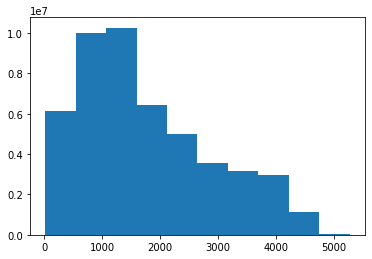

In [ ]:
plt.fig = plt.figure()
plt.hist(values.numpy())
plt.show()

In [ ]:
(values).min()

tensor(16.5450)

Since values have positively skewed distribution take log transform. Since minimum value is 107, log transform without shift is possible.

In [ ]:
DSM[DSM != -1] = np.log(DSM[DSM != -1])

After log transform:

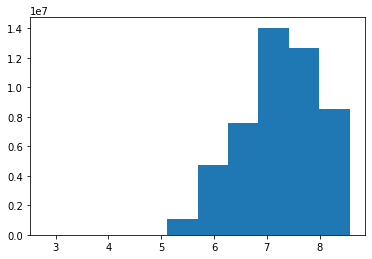

In [ ]:
values = (DSM != -1).nonzero()
values = DSM[ values[:,0] , values[:,1]].view(-1)
plt.fig = plt.figure()
plt.hist(values.numpy())
plt.show()

To transform in order to have normal distribution:
<br> rescale_image function defined bellow

In [ ]:
%cd ../
from Data_maker_loader import rescale_image
DSM  ,mean, std = rescale_image(DSM)
del rescale_image

/rdsgpfs/general/project/aandedemand/live/satellite/junin/deforestation_forecasting/python_code


In [ ]:
print("Mean after log transform: ", mean)
print("Std after log transform: ", std)

Mean after log transform:  tensor([7.2419])
Std after log transform:  tensor([0.7253])


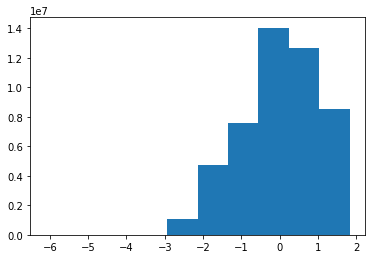

In [ ]:
values = (DSM[:,:] != -1).nonzero()
values = DSM[ values[:,0] , values[:,1]].view(-1)
plt.fig = plt.figure()
plt.hist(values.numpy())
plt.show()

In [ ]:
torch.save(DSM,wherepath+"/"+'DSM.pt')

### In summary, to include this layer do:

In [ ]:
DSM = to_Tensor(sourcepath,'DSM.tif')
DSM[datamask == -1 ] = -1
# If positive skewed distribution of the values:
min_val  = DSM[DSM != -1 ].min().numpy()
print("Min value of the elevation: ",min_val)
# if there is negative values and zero values log transform must be applied after a shift to positive values only.
# log(0) = -Inf
if min_val > 0:
    DSM[DSM != -1] = np.log(DSM[DSM != -1])
else:
    DSM[DSM != -1] = np.log(DSM[DSM != -1] + min_val + 1)
#Normalise:
DSM, DSMmean, DSMstd = rescale_image(DSM)
print("Extracted mean: ",DSMmean)
print("Devided std: ",DSMstd)

## **last_to_image**

The following function open the 4 rasters (one for each band) of the last files (eg last_18_1,..last_18_4) and returns them as a tensors of size (4, 14646, 15723)

<br>**path** is the sourcepath
<br>**year** any of 13,14,15,16,17,18

In [ ]:
def last_to_image(path,year):
    """
    Given path to folder having tiff files for each last band for given year
    returns Tensors with chanels == bands and year as requested in the path
    """
    image = []
    for b in range(1,5):
        band = Image.open(path+"/"+'Hansen/last_20%d_%d.tif'%(year,b))
        band = ToTensor()(band)
        image.append(band)
    image = torch.cat(image,dim = 0)
    image = image.float()
    return(image)

In [ ]:
start = time.time()
#Run this:###########
last_16 = last_to_image(sourcepath,16)
####################
print(last_16.shape)
print("Time needed to load one last file as tensor (in seconds): ",time.time() - start)

torch.Size([4, 17964, 16852])
Time needed to load one last file as tensor (in seconds):  41.979917764663696


## Rescale Image
<br> **rescale_image**

Get satelite image, compute the mean and std of all
non-masked pixels and returns a normalized satellite image.
Normalization is done per channel. Reason for that is that different channels have different means and
std. Mean and std are also conputed per year because images might be taken at different seasons and therefore the channels values distribution might be different.

### Here we illustrate the 4 channels values distributions  of year 2016 satellite image

In [ ]:
pixels = (last_16[1,:,:] != -1).nonzero()
values1 = last_16[0, pixels[:,0] , pixels[:,1]].view(-1)
values2 = last_16[1, pixels[:,0] , pixels[:,1]].view(-1)
values3 = last_16[2, pixels[:,0] , pixels[:,1]].view(-1)
values4 = last_16[3, pixels[:,0] , pixels[:,1]].view(-1)

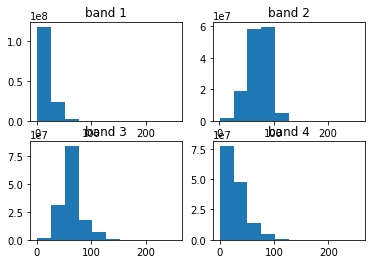

In [ ]:
plt.fig = plt.figure()
plt.subplot(2, 2, 1)
plt.hist(values1.numpy())
plt.title("band 1")
plt.subplot(2, 2, 2)
plt.hist(values2.numpy())
plt.title("band 2")
plt.subplot(2, 2, 3)
plt.hist(values3.numpy())
plt.title("band 3")
plt.subplot(2, 2, 4)
plt.hist(values4.numpy())
plt.title("band 4")
plt.show()

In [ ]:
def rescale_image(image):
    # detach and clone the image so that you don't modify the input, but are returning new tensor.
    rescaled_image = image.data.clone()
    if(len(image.shape) == 2):
        rescaled_image = rescaled_image.unsqueeze(dim = 0)
    # Compute mean and std only from non masked pixels
    # Spatial coordinates of this pixels are:
    pixels = (rescaled_image[0,:,:] != -1).nonzero()
    mean = rescaled_image[:, pixels[:,0] , pixels[:,1]].mean(1,keepdim=True)
    std = rescaled_image[:, pixels[:,0] , pixels[:,1]].std(1,keepdim=True)
    rescaled_image[:, pixels[:,0] , pixels[:,1]] -= mean
    rescaled_image[:, pixels[:,0] , pixels[:,1]] /= std
    if(len(image.shape) == 2):
        rescaled_image = rescaled_image.squeeze(dim = 0)
        mean = mean.squeeze(dim = 0)
        std = std.squeeze(dim = 0)
    return(rescaled_image,mean,std)

In [ ]:
st = time.time()
rescaled_image, mean, std = rescale_image(last_16)
print("Time to rescale one year image:",time.time() - st)
print("\nMean of channles : \n",mean)
print("\nStd of channles : \n",std)
print("\nOriginal image preserved: ",last_16[:,555,7777])
print("Rescaled values at this location: ",rescaled_image[:,555,7777])

Time to rescale one year image: 18.758196115493774

Mean of channles : 
 tensor([[18.5237],
        [72.7132],
        [63.6026],
        [31.1686]])

Std of channles : 
 tensor([[13.4344],
        [19.2726],
        [19.4598],
        [16.9414]])

Original image preserved:  tensor([-1., -1., -1., -1.])
Rescaled values at this location:  tensor([-1., -1., -1., -1.])
